In [29]:
import sys

sys.path.insert(0, "..")
from debug_intrinsic_selection import *


In [30]:
run_kwargs = read_json("test_event/run_1/run_kwargs.json")
run_kwargs

{'event_dir': 'test_event',
 'event': 'test_event.npz',
 'bank_folder': 'test_bank',
 'n_int': 4096,
 'n_ext': 1024,
 'n_phi': 64,
 'n_t': 64,
 'blocksize': 1024,
 'single_detector_blocksize': 1024,
 'i_int_start': 0,
 'seed': 42,
 'load_inds': False,
 'inds_path': None,
 'size_limit': 1000000,
 'draw_subset': False,
 'n_draws': None,
 'rundir': 'test_event/run_1',
 'coherent_score_min_n_effective_prior': 100,
 'max_incoherent_lnlike_drop': 1000.0,
 'mchirp_guess': None,
 'extrinsic_samples': None,
 'n_phi_incoherent': 32,
 'preselected_indices': None}

In [31]:
event = "test_event.npz"
bank_folder = "test_bank"
n_int = 2**12
n_ext = 512
n_phi = 64
n_t = 64
blocksize = 1024
single_detector_blocksize = 1024
i_int_start = 0
seed = 42
load_inds = False
inds_path = None
size_limit = 10**6
draw_subset = False
n_draws = None
event_dir = "test_event"
rundir = None
coherent_score_min_n_effective_prior = 100
max_incoherent_lnlike_drop = 1000
max_bestfit_lnlike_diff = 20
mchirp_guess = None
extrinsic_samples = None
n_phi_incoherent = 32
preselected_indices = None
coherent_posterior_kwargs = {}


In [32]:
# Variable control - not interesting
"""Run the magic integral for a given event and bank folder."""
bank_folder = Path(bank_folder)
print("Setting paths & loading configurations...")
if event_dir is not None and rundir is not None:
    warnings.warn(
        "Both 'event_dir' and 'rundir' are provided. 'event_dir' will be ignored."
    )
if rundir is None:
    rundir = get_rundir(event_dir)

if not Path(rundir).exists():
    mkdirs(rundir)
with open(rundir / "run_kwargs.json", "w", encoding="utf-8") as fp:
    json.dump(
        {
            "event_dir": str(event_dir),
            "event": str(event),
            "bank_folder": str(bank_folder),
            "n_int": int(n_int),
            "n_ext": int(n_ext),
            "n_phi": int(n_phi),
            "n_t": int(n_t),
            "blocksize": int(blocksize),
            "single_detector_blocksize": int(single_detector_blocksize),
            "i_int_start": int(i_int_start),
            "seed": int(seed) if seed is not None else None,
            "load_inds": bool(load_inds),
            "inds_path": str(inds_path) if inds_path is not None else None,
            "size_limit": int(size_limit),
            "draw_subset": bool(draw_subset),
            "n_draws": int(n_draws) if n_draws is not None else None,
            "rundir": str(rundir),
            "coherent_score_min_n_effective_prior": int(
                coherent_score_min_n_effective_prior
            ),
            "max_incoherent_lnlike_drop": float(max_incoherent_lnlike_drop),
            "mchirp_guess": float(mchirp_guess) if mchirp_guess is not None else None,
            "extrinsic_samples": str(extrinsic_samples)
            if extrinsic_samples is not None
            else None,
            "n_phi_incoherent": int(n_phi_incoherent)
            if n_phi_incoherent is not None
            else None,
            "preselected_indices": str(preselected_indices)
            if isinstance(preselected_indices, (str, Path))
            else ("array" if preselected_indices is not None else None),
        },
        fp,
        indent=4,
    )
# set paths and basic configs
event_data = get_event_data(event)
bank_config_path = Path(bank_folder) / "bank_config.json"
if isinstance(inds_path, str):
    inds_path = Path(inds_path)
with open(bank_config_path, "r", encoding="utf-8") as fp:
    bank_config = json.load(fp)
    fbin = np.array(bank_config["fbin"])
    approximant = bank_config["approximant"]
    f_ref = bank_config["f_ref"]
    m_arr = np.array(bank_config["m_arr"])


Setting paths & loading configurations...


In [33]:
print("Creating COGWHEEL objects...")
coherent_posterior_kwargs = (
    coherent_posterior_kwargs if coherent_posterior_kwargs else {}
)
posterior_kwargs = {
    "likelihood_class": RelativeBinningLikelihood,
    "approximant": approximant,
    "prior_class": "CartesianIASPrior",
} | coherent_posterior_kwargs

likelihood_kwargs = {"fbin": fbin, "pn_phase_tol": None}
if "likelihood_kwargs" in posterior_kwargs:
    likelihood_kwargs = likelihood_kwargs | posterior_kwargs.pop("likelihood_kwargs")

ref_wf_finder_kwargs = {"time_range": (-1e-1, +1e-1), "f_ref": f_ref}
if "ref_wf_finder_kwargs" in posterior_kwargs:
    ref_wf_finder_kwargs = ref_wf_finder_kwargs | posterior_kwargs.pop(
        "ref_wf_finder_kwargs"
    )
coherent_posterior = Posterior.from_event(
    event=event_data,
    mchirp_guess=mchirp_guess,
    likelihood_kwargs=likelihood_kwargs,
    ref_wf_finder_kwargs=ref_wf_finder_kwargs,
    **posterior_kwargs,
)
par_dic_0 = coherent_posterior.likelihood.par_dic_0.copy()

coherent_posterior.to_json(dirname=rundir)


Creating COGWHEEL objects...
Searching incoherent solution for test_event
Set intrinsic parameters, lnL = 69.76447577207959
Set time, lnL(L) = 69.8335284462418
Set sky location, lnL = 69.83352849459472
Set phase and distance, lnL = 69.83352849459472
Set mchirp_range = (np.float64(17.603154257527994), np.float64(68.09013776936015))


In [36]:
print("Collecting intrinsic samples from individual detectors...")
# Use n_phi_incoherent for single detector evaluation (thresholding)
n_phi_incoherent = n_phi_incoherent if n_phi_incoherent is not None else n_phi
inds, lnlikes_di, incoherent_lnlikes = collect_int_samples_from_single_detectors(
    event_data=event_data,
    par_dic_0=par_dic_0,
    single_detector_blocksize=single_detector_blocksize,
    n_int=n_int,
    n_phi=n_phi_incoherent,
    n_t=n_t,
    bank_folder=bank_folder,
    i_int_start=i_int_start,
    max_incoherent_lnlike_drop=max_incoherent_lnlike_drop,
    preselected_indices=preselected_indices,
)


REFERNCE_RESULTS = {
    "inds": inds,
    "lnlikes_di": lnlikes_di,
    "incoherent_lnlikes": incoherent_lnlikes,
}

Processing intrinsic batches: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


In [39]:
print(REFERNCE_RESULTS["incoherent_lnlikes"])
print(REFERNCE_RESULTS["lnlikes_di"])


[20.33230871 34.92310574 21.8101996  ... 40.75357702 18.93181681
 19.32700203]
[[20.33230871 34.92310574 21.8101996  ... 40.75357702
  18.93181681 19.32700203]]


### go into the code inference->collect_int_samples_from_single_detectors -> run_for_single_detector

In [40]:
event_data
det_name = "L"
par_dic_0
bank_folder
inds = np.arange(0, 4096)
fbin = coherent_posterior.likelihood.fbin
h_impb = None
approximant = "IMRPhenomXODE"
n_phi
single_detector_blocksize - 512
m_arr = np.array([2, 1, 3, 4])
n_t
size_limit

1000000

In [41]:
if isinstance(event_data, Path):
    event_data_path = event_data
    event_data_1d = EventData.from_npz(filename=event_data_path)
else:
    event_data_1d = copy.deepcopy(event_data)
indices = [event_data_1d.detector_names.index(det) for det in list(det_name)]


array_attributes = ["strain", "blued_strain", "wht_filter"]
for attr in array_attributes:
    setattr(event_data_1d, attr, getattr(event_data_1d, attr)[indices])

tuple_attributes = [
    "detector_names",
]
for attr in tuple_attributes:
    temp = tuple(np.take(getattr(event_data_1d, attr), indices))
    setattr(event_data_1d, attr, temp)
if getattr(event_data_1d, "injection", None) is not None:
    event_data_1d.injection["h_h"] = np.take(
        event_data_1d.injection["h_h"], indices
    ).tolist()
    event_data_1d.injection["d_h"] = np.take(
        event_data_1d.injection["d_h"], indices
    ).tolist()
wfg = WaveformGenerator.from_event_data(event_data_1d, approximant)

likelihood_linfree = LinearFree(event_data_1d, wfg, par_dic_0, fbin)
bank_file_path = Path(bank_folder) / "intrinsic_sample_bank.feather"
waveform_dir = Path(bank_folder) / "waveforms"

sdp = SingleDetectorProcessor(
    bank_file_path,
    waveform_dir,
    n_phi,
    m_arr,
    likelihood_linfree,
    size_limit=size_limit,
    ext_block_size=single_detector_blocksize,
    int_block_size=single_detector_blocksize,
)

In [42]:
# check : is the loading process consistent?

# erase the cache


def check_loading_consistency(sdp):
    sdp.intrinsic_sample_processor.cached_dt_linfree_relative = {}

    # load once
    amp, phase = sdp.intrinsic_sample_processor.load_amp_and_phase(waveform_dir, inds)
    h1 = amp * np.exp(1j * phase)

    # load twice

    amp, phase = sdp.intrinsic_sample_processor.load_amp_and_phase(waveform_dir, inds)
    h2 = amp * np.exp(1j * phase)

    are_equal = np.array_equal(h1, h2)
    max_abs_diff = np.max(np.abs(h1 - h2))
    with np.errstate(divide="ignore", invalid="ignore"):
        rel_diff = np.abs(h1 - h2) / np.where(np.abs(h1) > 0, np.abs(h1), 1)
        max_rel_diff = np.max(rel_diff)

    print(f"Are h1 and h2 exactly equal? {are_equal}")
    print(f"Maximum absolute difference: {max_abs_diff}")
    print(f"Maximum relative difference: {max_rel_diff}")


check_loading_consistency(sdp)

Are h1 and h2 exactly equal? True
Maximum absolute difference: 0.0
Maximum relative difference: 0.0


In [43]:
if h_impb is None:
    return_h_impb = True
    amp, phase = sdp.intrinsic_sample_processor.load_amp_and_phase(waveform_dir, inds)
    h_impb = amp * np.exp(1j * phase)
else:
    return_h_impb = False

sdp.h_impb = h_impb


# fix sky position to above detector
det_name = sdp.likelihood.event_data.detector_names[0]
tgps = sdp.likelihood.event_data.tgps
lat, lon = skyloc_angles.cart3d_to_latlon(
    skyloc_angles.normalize(DETECTORS[det_name].location)
)

par_dic = sdp.transform_par_dic_by_sky_poisition(det_name, par_dic_0, lon, lat, tgps)

delay = get_geocenter_delays(det_name, par_dic["lat"], par_dic["lon"])[0]
tcoarse = sdp.likelihood.event_data.tcoarse
t_grid = (np.arange(n_t) - n_t // 2) * (sdp.likelihood.event_data.times[1])
t_grid += par_dic["t_geocenter"] + tcoarse + delay

timeshifts_dbt = np.exp(
    -2j * np.pi * t_grid[None, None, :] * sdp.likelihood.fbin[None, :, None]
)

In [94]:
DETECTORS[det_name].location

array([  -74276.0447238, -5496283.71971  ,  3224257.01744  ])

In [44]:
r_iotp, lnlike_iot = sdp.get_response_over_distance_and_lnlike(
    sdp.dh_weights_dmpb,
    sdp.hh_weights_dmppb,
    sdp.h_impb,
    timeshifts_dbt,
    sdp.likelihood.asd_drift,
    sdp.likelihood_calculator.n_phi,
    sdp.likelihood_calculator.m_arr,
)

In [64]:
print(lnlike_iot.max(axis=(1, 2)))
print(REFERNCE_RESULTS["incoherent_lnlikes"])

[20.33230871 34.97490395 21.8101996  ... 40.76375373 19.03133498
 19.36449907]
[20.33230871 34.92310574 21.8101996  ... 40.75357702 18.93181681
 19.32700203]


In [89]:
# convert indices to actual parameters
from dot_pe import single_detector


i = 0
t = 5
o = 6
t_geocenter = (
    par_dic["t_geocenter"]
    + t_grid[t]
    - tcoarse
    - delay
    - sdp.intrinsic_sample_processor.cached_dt_linfree_relative[i]
)
phi_ref = o / n_phi_incoherent * np.pi * 2

intrinsic_params = (
    pd.read_feather(bank_folder / "intrinsic_sample_bank.feather").iloc[i].to_dict()
) | {"l1": 0, "l2": 0, "f_ref": read_json(bank_folder / "bank_config.json")["f_ref"]}

ra = par_dic["ra"]
dec = par_dic["dec"]

psi, d_luminosity = sdp.bestfit_response_to_psi_and_d_luminosity(
    r_iotp[i, o, t], det_name
)

optimized_par_dic = intrinsic_params | dict(
    ra=ra,
    dec=dec,
    t_geocenter=t_geocenter,
    phi_ref=phi_ref,
    psi=psi,
    d_luminosity=d_luminosity,
)

print(coherent_posterior.likelihood.lnlike(optimized_par_dic))

1.8003300139843232


In [91]:
print(coherent_posterior.likelihood.lnlike(par_dic_0))
print(coherent_posterior.likelihood.lnlike(par_dic))

71.94360944502293
71.94360944496185


In [84]:
lnlike_iot[i, o, t]

np.float64(2.6098145724963757)

In [70]:
sdp.intrinsic_sample_processor.load_bank(bank_folder / "intrinsic_sample_bank.feather")

,m1,m2,s1z,s1x_n,s1y_n,s2z,s2x_n,s2y_n,iota,log_prior_weights,original_index,l1,l2,f_ref
0,50.916176,12.133119,0.012870,0.137098,-0.409679,-0.059172,-0.400938,0.386496,0.909082,-0.326086,0,0.0,0.0,50.0
1,32.771246,25.785593,0.801655,0.350169,0.238606,-0.112725,0.190590,0.237302,2.475914,-0.012838,1,0.0,0.0,50.0
2,40.544640,17.556335,-0.971193,0.135283,0.138550,-0.407934,-0.157002,0.586097,1.498191,-0.184387,2,0.0,0.0,50.0
3,77.220024,15.079445,0.818345,-0.359745,0.439332,0.699975,0.038845,-0.667461,0.970193,0.307785,3,0.0,0.0,50.0
4,31.199023,20.117033,-0.618978,0.477139,0.131724,-0.062927,0.794732,0.157599,1.873992,-0.310252,4,0.0,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,59.016676,18.239000,0.422085,0.004991,0.817685,0.625781,0.478591,0.300095,0.464435,0.229176,4091,0.0,0.0,50.0
4092,51.169538,12.959150,-0.888274,0.355435,0.029853,-0.104188,-0.037255,-0.416378,2.822463,-0.255259,4092,0.0,0.0,50.0
4093,33.035013,27.625301,0.976494,-0.004630,-0.077389,0.743036,0.273029,0.488133,2.463380,0.064094,4093,0.0,0.0,50.0
4094,40.801722,18.777046,-0.375139,-0.060960,0.806314,-0.231362,-0.296629,0.484653,1.689052,-0.110846,4094,0.0,0.0,50.0


In [71]:
intrinsic_params

,m1,m2,s1z,s1x_n,s1y_n,s2z,s2x_n,s2y_n,iota,log_prior_weights
0,50.916176,12.133119,0.012870,0.137098,-0.409679,-0.059172,-0.400938,0.386496,0.909082,-0.326027
1,32.771246,25.785593,0.801655,0.350169,0.238606,-0.112725,0.190590,0.237302,2.475914,-0.012779
2,40.544640,17.556335,-0.971193,0.135283,0.138550,-0.407934,-0.157002,0.586097,1.498191,-0.184328
3,77.220024,15.079445,0.818345,-0.359745,0.439332,0.699975,0.038845,-0.667461,0.970193,0.307845
4,31.199023,20.117033,-0.618978,0.477139,0.131724,-0.062927,0.794732,0.157599,1.873992,-0.310193
...,...,...,...,...,...,...,...,...,...,...
4091,59.016676,18.239000,0.422085,0.004991,0.817685,0.625781,0.478591,0.300095,0.464435,0.229235
4092,51.169538,12.959150,-0.888274,0.355435,0.029853,-0.104188,-0.037255,-0.416378,2.822463,-0.255200
4093,33.035013,27.625301,0.976494,-0.004630,-0.077389,0.743036,0.273029,0.488133,2.463380,0.064153
4094,40.801722,18.777046,-0.375139,-0.060960,0.806314,-0.231362,-0.296629,0.484653,1.689052,-0.110787


In [28]:
lnlike_iot.max(axis=(1, 2)), lnlike_iot.shape

(array([14.53437835, 36.00738328, 23.37132227, ..., 42.8495531 ,
        23.53729514, 16.59238524], shape=(4096,)),
 (4096, 64, 64))

# Aside: make sure that the linear-free timeshift does what I think it does

In [123]:
i = 10
_ = sdp.intrinsic_sample_processor.load_waveforms(waveform_dir, np.array([10]))

intrinsic_params = (
    pd.read_feather(bank_folder / "intrinsic_sample_bank.feather").iloc[i].to_dict()
) | {"l1": 0, "l2": 0, "f_ref": read_json(bank_folder / "bank_config.json")["f_ref"]}

extrinsic_params = {} | {
    "t_geocenter": 0.0,
    "d_luminosity": 1.0,
    "phi_ref": 0.0,
    "psi": 0.0,
}

h1 = coherent_posterior.likelihood.waveform_generator.get_hplus_hcross(
    waveform_par_dic=intrinsic_params | extrinsic_params,
    f=coherent_posterior.likelihood.fbin,
    by_m=True,
)

In [134]:
h2 = np.load(waveform_dir / "amplitudes_block_0.npy")[i] * np.exp(
    1j * np.load(waveform_dir / "phase_block_0.npy")[i]
)

In [135]:
h1[0][0] - h2[0][0]

array([ 0.00000000e+00+0.00000000e+00j,
       -6.01853108e-36+7.52316385e-36j,
        6.01853108e-36-1.20370622e-35j, ...,
        0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j], shape=(378,))

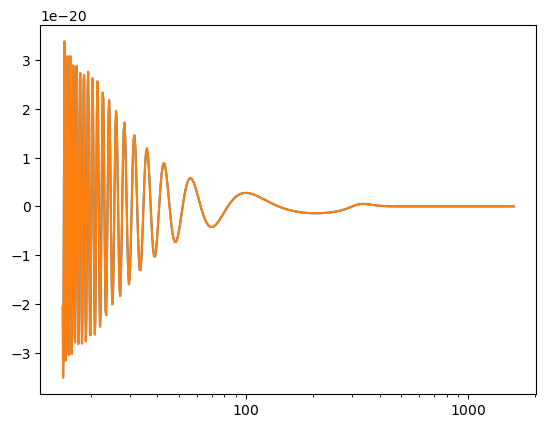

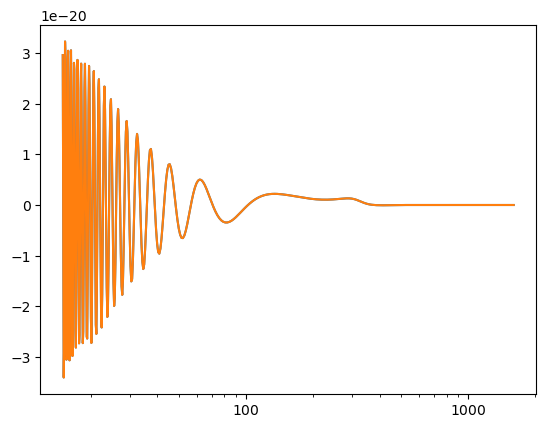

In [138]:
import matplotlib.pyplot as plt

plt.semilogx(fbin, h1[0, 0].real)
plt.semilogx(fbin, h2[0, 0].real)

plt.figure()
import matplotlib.pyplot as plt

plt.semilogx(fbin, h1[0, 0].imag)
plt.semilogx(fbin, h2[0, 0].imag)